# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import imageio as imageio

import os

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from test_utils import summary, comparator

===============================================================================================

# Importing & Visualizing Data

In [7]:
path = ''
image_path = os.path.join(path, 'data/RGB Images/')
mask_path = os.path.join(path, 'data/Segmented Images/')

In [8]:
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)

In [9]:
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [10]:
len(image_list)

1000

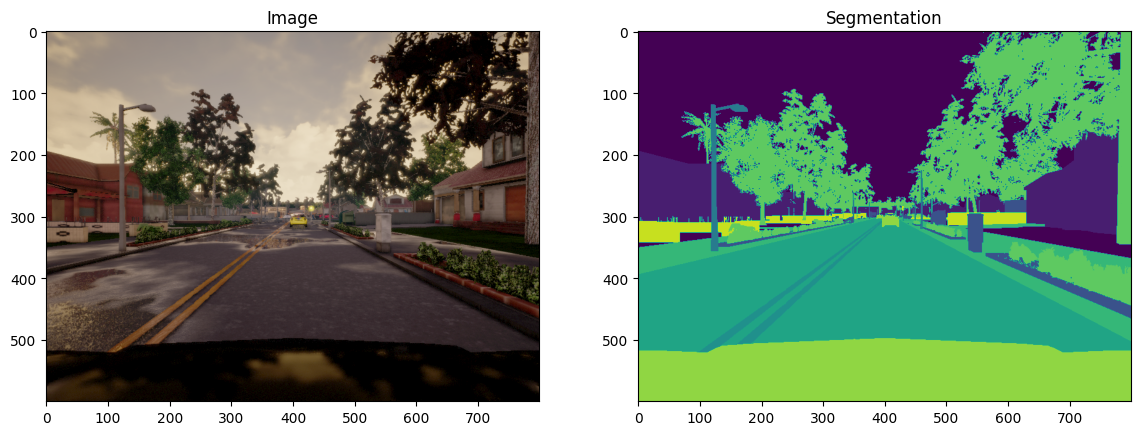

In [12]:
N = 3
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

with plt.style.context('default'):
    fig, arr = plt.subplots(1, 2, figsize=(14, 10))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[1].imshow(mask[:, :, 0])
    arr[1].set_title('Segmentation')

===============================================================================================

# Splitting the Data

In [13]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

In [14]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

===============================================================================================

# Data PreProcessing

In [8]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

===============================================================================================

# U-NET

## Encoder

In [15]:

def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
   

    conv = Conv2D(n_filters, 
                  3,  
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, 
                  3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    

    if dropout_prob > 0:
         
        conv = Dropout(dropout_prob)(conv)
         
         
    if max_pooling:
        
        next_layer = MaxPooling2D(2,strides=2)(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    
    return next_layer, skip_connection

In [16]:
input_size=(96, 128, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output1 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output2 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', (None, 96, 128, 1024), 0, 0.1],
            ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]]
           
print('\nBlock 2:')   
for layer in summary(model2):
    print(layer)
    
comparator(summary(model2), output2)

Block 1:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal']
['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]
All tests passed!

Block 2:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal']
['Dropout', (None, 96, 128, 1024), 0, 0.1]
['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]
All tests passed!


## Decoder

In [17]:

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,    
                 3,
                 strides=2,
                 padding='same')(expansive_input)
    
    
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, 
                  3,  
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, 
                  3,  
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
   
    
    return conv

In [18]:
input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

output1 = [['InputLayer', [(None, 12, 16, 256)], 0],
            ['Conv2DTranspose', (None, 24, 32, 32), 73760],
            ['InputLayer', [(None, 24, 32, 128)], 0],
            ['Concatenate', (None, 24, 32, 160), 0],
            ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

Block 1:
['InputLayer', [(None, 12, 16, 256)], 0]
['Conv2DTranspose', (None, 24, 32, 32), 73760]
['InputLayer', [(None, 24, 32, 128)], 0]
['Concatenate', (None, 24, 32, 160), 0]
['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']
All tests passed!


===============================================================================================

# Building the Model

In [19]:

def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
   
    inputs = Input(input_size)

    
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 

    

    
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)
    

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [20]:
import outputs
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
comparator(summary(unet), outputs.unet_model_output)


All tests passed!


===============================================================================================

In [21]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [22]:
unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 96, 128, 32)  896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 96, 128, 32)  9248        conv2d_26[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 48, 64, 32)   0           conv2d_27[0][0]                  
____________________________________________________________________________________________

In [23]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

===============================================================================================

# Training the Model

In [21]:
EPOCHS = 100
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/100
32/32 [==============================] - 35s 435ms/step - loss: 2.7311 - accuracy: 0.2677
Epoch 2/100
32/32 [==============================] - 4s 134ms/step - loss: 1.5198 - accuracy: 0.4522
Epoch 3/100
32/32 [==============================] - 4s 135ms/step - loss: 0.9398 - accuracy: 0.6472
Epoch 4/100
32/32 [==============================] - 4s 134ms/step - loss: 0.8187 - accuracy: 0.6854
Epoch 5/100
32/32 [==============================] - 4s 135ms/step - loss: 0.7123 - accuracy: 0.7440
Epoch 6/100
32/32 [==============================] - 4s 135ms/step - loss: 0.6079 - accuracy: 0.7833
Epoch 7/100
32/32 [==============================] - 4s 136ms/step - loss: 0.5478 - accuracy: 0.8131
Epoch 8/100
32/32 [==============================] - 4s 136ms/step - loss: 0.5137 - accuracy: 0.8300
Epoch 9/100
32/32 [==============================] - 4s 137ms/step - l

===============================================================================================

# Predicted Masks 

In [22]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


# Plotting Model Accuracy

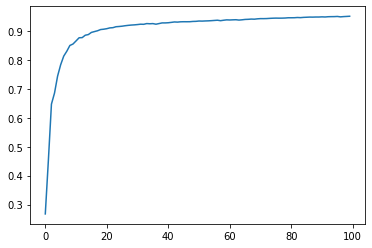

In [23]:
plt.plot(model_history.history["accuracy"])

===============================================================================================

# Predictions 

In [24]:
def show_predictions(dataset=None, num=1):
  
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 249ms/step


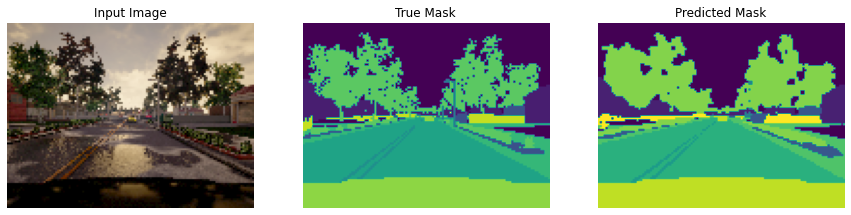

1/1 [==============================] - 0s 19ms/step


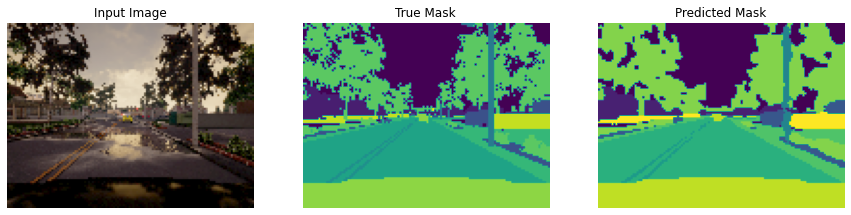

1/1 [==============================] - 0s 22ms/step


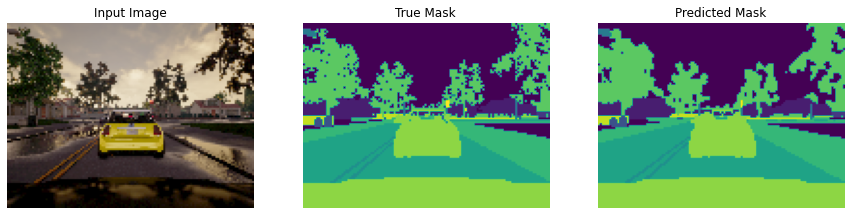

1/1 [==============================] - 0s 22ms/step


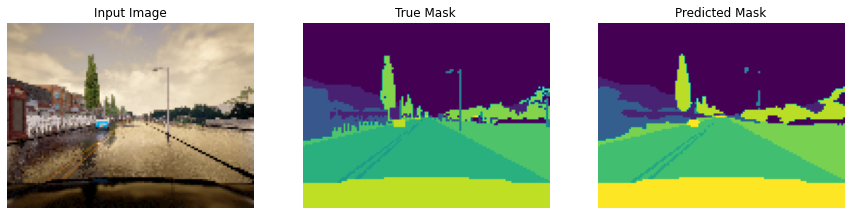

1/1 [==============================] - 0s 34ms/step


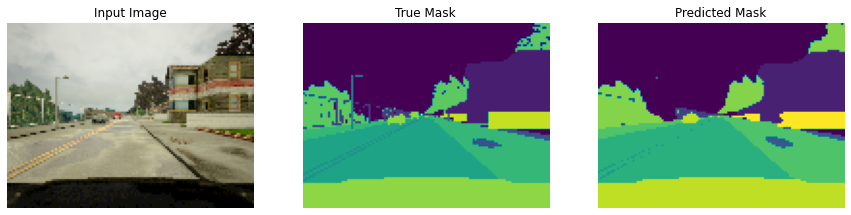

1/1 [==============================] - 0s 19ms/step


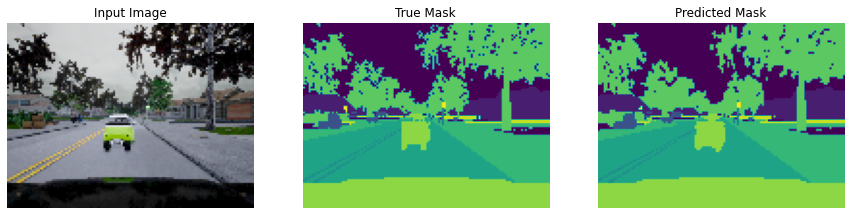

In [25]:
show_predictions(train_dataset, 6)

===============================================================================================